In [45]:
import numpy as np
import scipy as sp
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt
import pickle

### Data Generation

In [92]:
class Model:
    def __init__(self, time_length):
        self.T = time_length
        self.num_treatments = 1
        self.X = np.zeros((self.T, self.num_treatments))
        self.A = np.array([[-.5], [-.2]]) # the coefficients a_j's stored in a matrix
        self.b = np.array([.4])
        self.c = np.array([1])
        self.noise_0 = .01
        self.noise_1 = .01
        self.noise_2 = .01
        self.init_z = 6
        self.z = np.zeros(time_length)
        self.y = np.zeros(time_length)
        self.pi = np.zeros(time_length)
        
    def set_X(self):
        for t in range(self.T):
            self.X[t, :] = np.random.randint(2, size = self.num_treatments)
    
    def transition(self, prev):
        z = np.random.normal(prev, model.noise_1, 1)
        return z

    def emission(self, z, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c) # total added effect
        mean = z + pi
        y = np.random.normal(mean, self.noise_2, 1)
        return y, pi
    
    def run_simulation(self):
        self.set_X()
        self.z[0] = np.random.normal(self.init_z, np.sqrt(self.noise_0), 1)
        self.y[0], self.pi[0] = self.emission(self.z[0], 0)
        for t in range(1, self.T):
            self.z[t] = self.transition(self.z[t-1])
            self.y[t], self.pi[t] = self.emission(self.z[t], t)
    
    def plot_trajectory(self):
        times = list(range(self.T))
        plt.plot(times, self.y, label = 'observed')
        plt.plot(times, self.z, label = 'counterfactual')
        for t in np.nonzero(self.X)[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        plt.show()

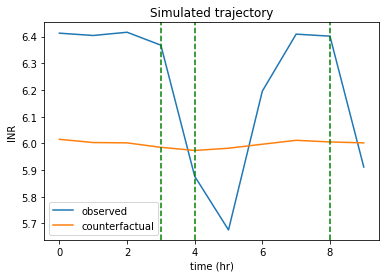

In [93]:
model = Model(10)
model.run_simulation()
model.plot_trajectory()

### EM

In [97]:
class EM:
    def __init__(self, y, X, c, N, M, K, J):
        # Store observed sequence, treatments, chronic conditions
        self.T = np.shape(y)[0] # length of the observed sequence
        self.y = y
        self.X = X # treatment matrix
        self.c = c # chronic conditions
        self.Q = np.zeros((self.T, K)) # interaction term
        
        # Fixed model parameters
        self.N = N # number of treatments
        self.M = M # number of chronic conditions
        self.K = K # number of interaction terms modeled
        self.J = J # number of past treatment effects to be considered
        
        # Model Parameters to be estimated
        self.A = np.zeros((J, N)) # coefficients a_j's
        self.b = np.zeros(M)
        self.d = np.zeros(K)
        self.sigma_1 = .5
        self.sigma_2 = .5
        self.sigma_0 = .5 # initial state variance
        self.init_z = 4 # initial state mean
        
        # create coefficient matrix
        columns = []
        for j in range(1, self.J+1):
            col = np.roll(self.X, shift=j, axis=0)
            col[[i for i in range(0, j)], :] = 0
            columns.append(col)
        C = np.stack([self.c for i in range(self.T)], axis = 0)
        columns.append(C)
        #q_col = np.roll(self.Q, shift=1, axis = 0)
        #q_col[0, :] = 0
        #columns.append(q_col)
        self.coeff_mtx = np.concatenate(columns, axis = 1)    
        
        # Intermediate values to stored
        self.mu_filter = np.zeros(self.T) # mu_t|t
        self.sigma_filter = np.zeros(self.T) # sigma^2_t|t
        self.kgain = np.zeros(self.T) # K_t, kalman gain
        self.jgain = np.zeros(self.T) # J_t, backward kalman gain 
        self.mu_smooth = np.zeros(self.T) # mu_t|T
        self.sigma_smooth = np.zeros(self.T) # sigma^2_t|T
        self.mu_square_smooth = np.zeros(self.T) # E[z_t^2|{y}]
        self.mu_ahead_smooth = np.zeros(self.T) # E[z_t * z_{t-1}|{y}]
        self.sigma_ahead_smooth = np.zeros(self.T)

    def set_params(self):
        self.A = model.A
        self.b = model.b
        self.sigma_0 = model.noise_0
        self.sigma_1 = model.noise_1
        self.sigma_2 = model.noise_2
        self.init_z = model.init_z    
    
    # compute the added effect, denoted pi_t, at time t given the current parameter values 
    def added_effect(self, t):
        treatment_effect = 0
        for j in range(self.J):
            if t-1 >= j:
                treatment_effect = treatment_effect + np.dot(self.A[j, :], self.X[t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c) # total added effect
        return pi
    
    '''E Step Calculations'''
    # kalman filter update step
    def kfilter(self, t):
        self.kgain[t+1] = (self.sigma_0 + t * self.sigma_1) / (self.sigma_0 + t * self.sigma_1 + self.sigma_2)
        mu_pred = self.mu_filter[t] 
        self.mu_filter[t+1] = mu_pred + self.kgain[t+1] * (self.y[t+1] - mu_pred - self.added_effect(t+1))
        sigma_pred = self.sigma_filter[t] + self.sigma_1
        self.sigma_filter[t+1] = (1 - self.kgain[t+1]) * sigma_pred
    
    # kalman filter for each time point, message passing forward
    def forward(self):
        self.mu_filter[0] = self.init_z
        self.sigma_filter[0] = self.sigma_0
        for t in range(self.T-1):
            self.kfilter(t)
    
    # kalman smoother update step
    def ksmoother(self, t):
        sigma_pred = self.sigma_filter[t] + self.sigma_1 # sigma^2_t+1|t
        self.jgain[t] = self.sigma_filter[t] / sigma_pred
        self.mu_smooth[t] = self.mu_filter[t] + self.jgain[t] * (self.mu_smooth[t+1] - self.mu_filter[t])
        self.sigma_smooth[t] = self.sigma_filter[t] + np.square(self.jgain[t]) * (self.sigma_smooth[t+1] - sigma_pred)
        self.mu_square_smooth[t] = self.sigma_smooth[t] + np.square(self.mu_smooth[t])
    
    def backward(self):
        self.mu_smooth[self.T-1] = self.mu_filter[self.T-1]
        self.sigma_smooth[self.T-1] = self.sigma_filter[self.T-1]
        self.mu_square_smooth[self.T-1] = self.sigma_smooth[self.T-1] + np.square(self.mu_smooth[self.T-1])
        for t in range(self.T-2, -1, -1):
            self.ksmoother(t)     
    
    # backward recursion to compute sigma^2_{t, t-1}|T, which is necessary to compute mu_ahead_smooth
    def backward_sigma_ahead(self, t):
        if t == self.T-2:
            self.sigma_ahead_smooth[t] = (1 - self.kgain[t]) * self.sigma_smooth[t]
            return self.sigma_ahead_smooth[t]
        else:
            sigma_ahead = self.backward_sigma_ahead(t+1)
            self.sigma_ahead_smooth[t] = self.sigma_smooth[t] * self.jgain[t-1] + \
                self.jgain[t] * (sigma_ahead - self.sigma_smooth[t]) * self.jgain[t-1]
            return self.sigma_ahead_smooth[t]
    
    def calc_mu_ahead_smooth(self):
        for t in range(self.T-1):
            self.mu_ahead_smooth[t] = self.sigma_ahead_smooth[t] + self.mu_smooth[t] * self.mu_smooth[t+1]
    
    def E_step(self):
        self.forward()
        self.backward()
        self.backward_sigma_ahead(0)
        self.calc_mu_ahead_smooth()
    
    '''M Step Calculations'''
    def sigma_0_mle(self):
        self.sigma_0 = self.mu_square_smooth[0] - np.square(self.mu_smooth[0])
    
    def sigma_1_mle(self):
        result = 0
        for t in range(self.T-1):
            result += self.mu_square_smooth[t+1]-2*self.mu_ahead_smooth[t]+self.mu_square_smooth[t]
        self.sigma_1 = result / (self.T-1)
    
    def init_z_mle(self):
        self.init_z = self.mu_smooth[0] 
    
    def pi_mle(self):  
        rhs = np.subtract(self.y, self.mu_smooth)
        print('rhs: {}'.format(rhs))
        params = sp.linalg.lstsq(self.coeff_mtx, rhs)[0] # params as a long vector
        print('params: {}'.format(params))
        self.A = np.reshape(params[0:self.N*self.J], (self.J, self.N))
        self.b = np.array(params[self.N*self.J:self.N*self.J+self.M])
        self.d = np.array(params[self.N*self.J+self.M:])       
    
    def M_step(self):
        self.init_z_mle()
        self.sigma_0_mle()
        self.sigma_1_mle()
        self.pi_mle()
    
    '''Run EM for fixed iterations'''
    def run_EM(self, num_iter):
        #self.set_params()
        for i in range(num_iter):
            self.E_step()
            self.M_step()
            self.plot()
               
    def plot(self):
        times = list(range(len(self.y)))
        plt.plot(times, self.y, label = 'observed values')
        plt.plot(times, model.z, label = 'true values')
        plt.plot(times, self.mu_filter, label = 'filtered values')
        plt.plot(times, self.mu_smooth, label = 'smoothened values')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Kalman Filter Results')
        plt.legend()
        plt.show()

rhs: [1.73205076 1.0424026  0.69482675 0.58139064 0.35145476 0.27475034
 0.43167456 0.4383601  0.45265869 0.35123544]
params: [-0.39343342 -0.25397666  0.80390582]


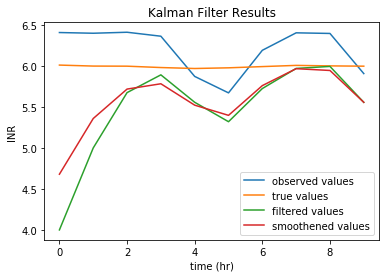

rhs: [1.44768374 1.1496147  0.98630426 0.87160029 0.38275686 0.13984005
 0.58058228 0.80569177 0.81611064 0.39629328]
params: [-0.57766743 -0.35237892  1.0014238 ]


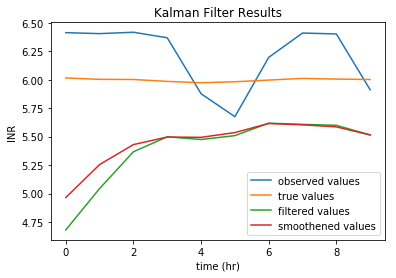

rhs: [1.30619085 1.1705208  1.09149528 0.98284737 0.42123424 0.14787553
 0.68496936 0.97110428 0.97658941 0.44026124]
params: [-0.62355615 -0.34771895  1.07591947]


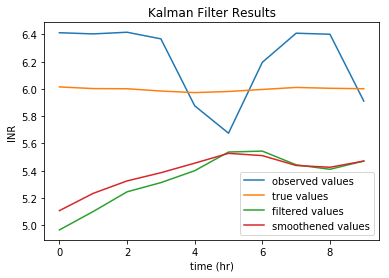

rhs: [1.23765294 1.16076424 1.11779834 1.02432204 0.46930939 0.21351522
 0.76100502 1.03514685 1.03447235 0.48366491]
params: [-0.60577668 -0.30668709  1.09683555]


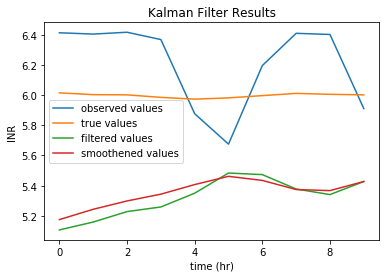

rhs: [1.20192767 1.15053268 1.12661693 1.04793056 0.51219968 0.27549655
 0.81374043 1.06409158 1.05891973 0.52106233]
params: [-0.57834011 -0.27120663  1.10499517]


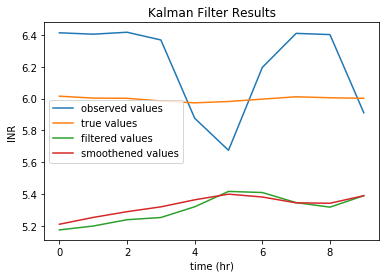

rhs: [1.18217517 1.14502191 1.13290244 1.06501511 0.54401913 0.31957113
 0.84932765 1.08313915 1.07560392 0.5508608 ]
params: [-0.55734137 -0.24855747  1.11167755]


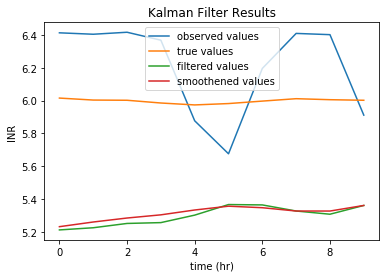

rhs: [1.17087111 1.14282734 1.13848513 1.07784609 0.56626515 0.3489498
 0.87348408 1.09791195 1.08933528 0.57340722]
params: [-0.54341604 -0.23504771  1.11797267]


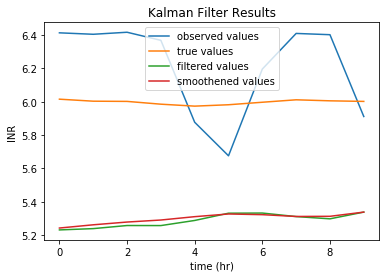

rhs: [1.16424585 1.14232042 1.14324141 1.08742281 0.58174665 0.36865132
 0.89019736 1.10943181 1.10043146 0.58999029]
params: [-0.53437188 -0.22683653  1.12344681]


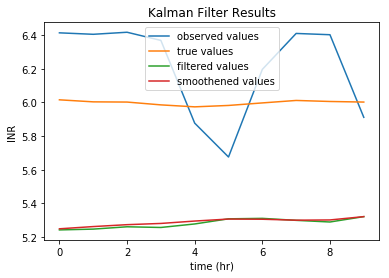

rhs: [1.16029606 1.14256025 1.14710086 1.09453353 0.5926575  0.38218555
 0.90199016 1.11822599 1.10905593 0.60205814]
params: [-0.52840437 -0.22162208  1.12791212]


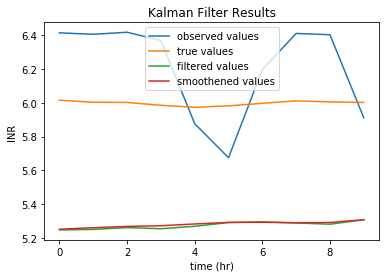

rhs: [1.15791989 1.14308891 1.15015145 1.09981587 0.60046575 0.39170553
 0.91044977 1.12484969 1.11560939 0.61083938]
params: [-0.52437604 -0.21817088  1.13143655]


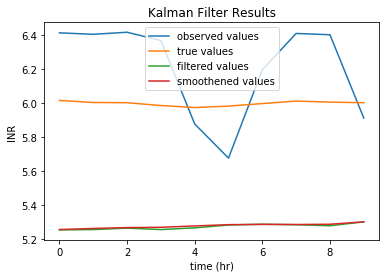

In [105]:
em = EM(model.y, model.X, model.c, 1, 1, 0, 2)
em.run_EM(10)

In [15]:
    # reduce the terms Q_function needs to unpack by computing some terms first
    # note that after E step, all except for the last term of Q function are constant
    def compute_Q_const(self):
        # compute terms involving logs
        log_term = -self.T * np.log(2*np.pi) - np.log(self.sigma_0)/2 - (self.T-1)/2 * np.log(self.sigma_1) \
         - self.T * self.sigma_2 / 2
        # compute the first term with expected value
        first_E = -1/(2*self.sigma_0)*(self.mu_smooth[0]-2*self.init_z*self.mu_smooth[0]+self.init_z^2)
        # compute the second term with expected value
        sqaure_term = np.roll(self.mu_square_smooth, -1)-2*self.mu_ahead_smooth+self.mu_square_smooth
        # delete the last value since mu_ahead_smooth has one less term
        square_term = np.delete(square_term, np.shape(square_term)[0]-1)
        second_E = -1/(2*self.sigma_1)*np.sum(square_term)
        self.Q_const = log_term + first_E + second_E

### Interpolation Methods